<a href="https://colab.research.google.com/github/suades/Diagnosing-MDD-using-Activity-Data/blob/main/Hour_Mean_Activity_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Depression Analysis

In [ ]:
#This first cell imports all the libraries we'll need access from like numpy, panda, matplotlib, and sklearn
import os
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
#This function will get “path” passed in then variable “dirs” uses os.listdir() to get a list of all the files and directories in path
#Then a for-each loop is used to check every file path and if it ends in .csv, panda will read the file
#and get every “timestamp” & “source” and add it to the combine_df array
def combine_data(path):
    dirs = os.listdir(path)
    combine_df = []

    for filepath in dirs:
        source = filepath.split('.')[0]
        if filepath.endswith('.csv'):
            X = pd.read_csv(path + filepath, parse_dates=['timestamp'], index_col='timestamp')
            X['source'] = source

            combine_df.append(X)

    return combine_df

In [ ]:
#Here we pass in the condition folder so combine_data can get all the information needed and put it in 1 array

combine_df = combine_data('/content/data/conditions/')

In [ ]:
#Now for each element in combine_df we get the mean and std activity, and the zero_activity_prop
conditions = []
for condition in combine_df:
    condition_df = pd.DataFrame(columns=['mean_activity', 'std_activity', 'zero_activity_proportion', 'source', 'state'])
    condition_df['mean_activity'] = condition.activity.resample('H').mean()
    condition_df['std_activity'] = condition.activity.resample('H').std()
    condition_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in condition.activity.resample('H')]
    condition_df['source'] = condition.source
    condition_df['state'] = 1
    conditions.append(condition_df)

In [ ]:
#Here we pass in the control folder so combine_data can get all the information needed and put it in 1 array
combine_df = combine_data('/content/data/control/')

In [ ]:
#This cell will do the same as the 2nd last cell before but with the control data now
controls = []
for control in combine_df:
    control_df = pd.DataFrame(columns=['mean_activity', 'std_activity', 'zero_activity_proportion', 'source', 'state'])
    control_df['mean_activity'] = control.activity.resample('H').mean()
    control_df['std_activity'] = control.activity.resample('H').std()
    control_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in control.activity.resample('H')]
    control_df['source'] = control.source
    control_df['state'] = 0
    controls.append(control_df)


In [ ]:
#This method converts x into a proper datetime format
def to_clock(x):
    d = datetime.strptime(f'{x}:00', '%H:%M')
    return d.strftime('%I:%M %p')

In [ ]:
import itertools
super_array = list(itertools.chain.from_iterable([conditions,controls]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


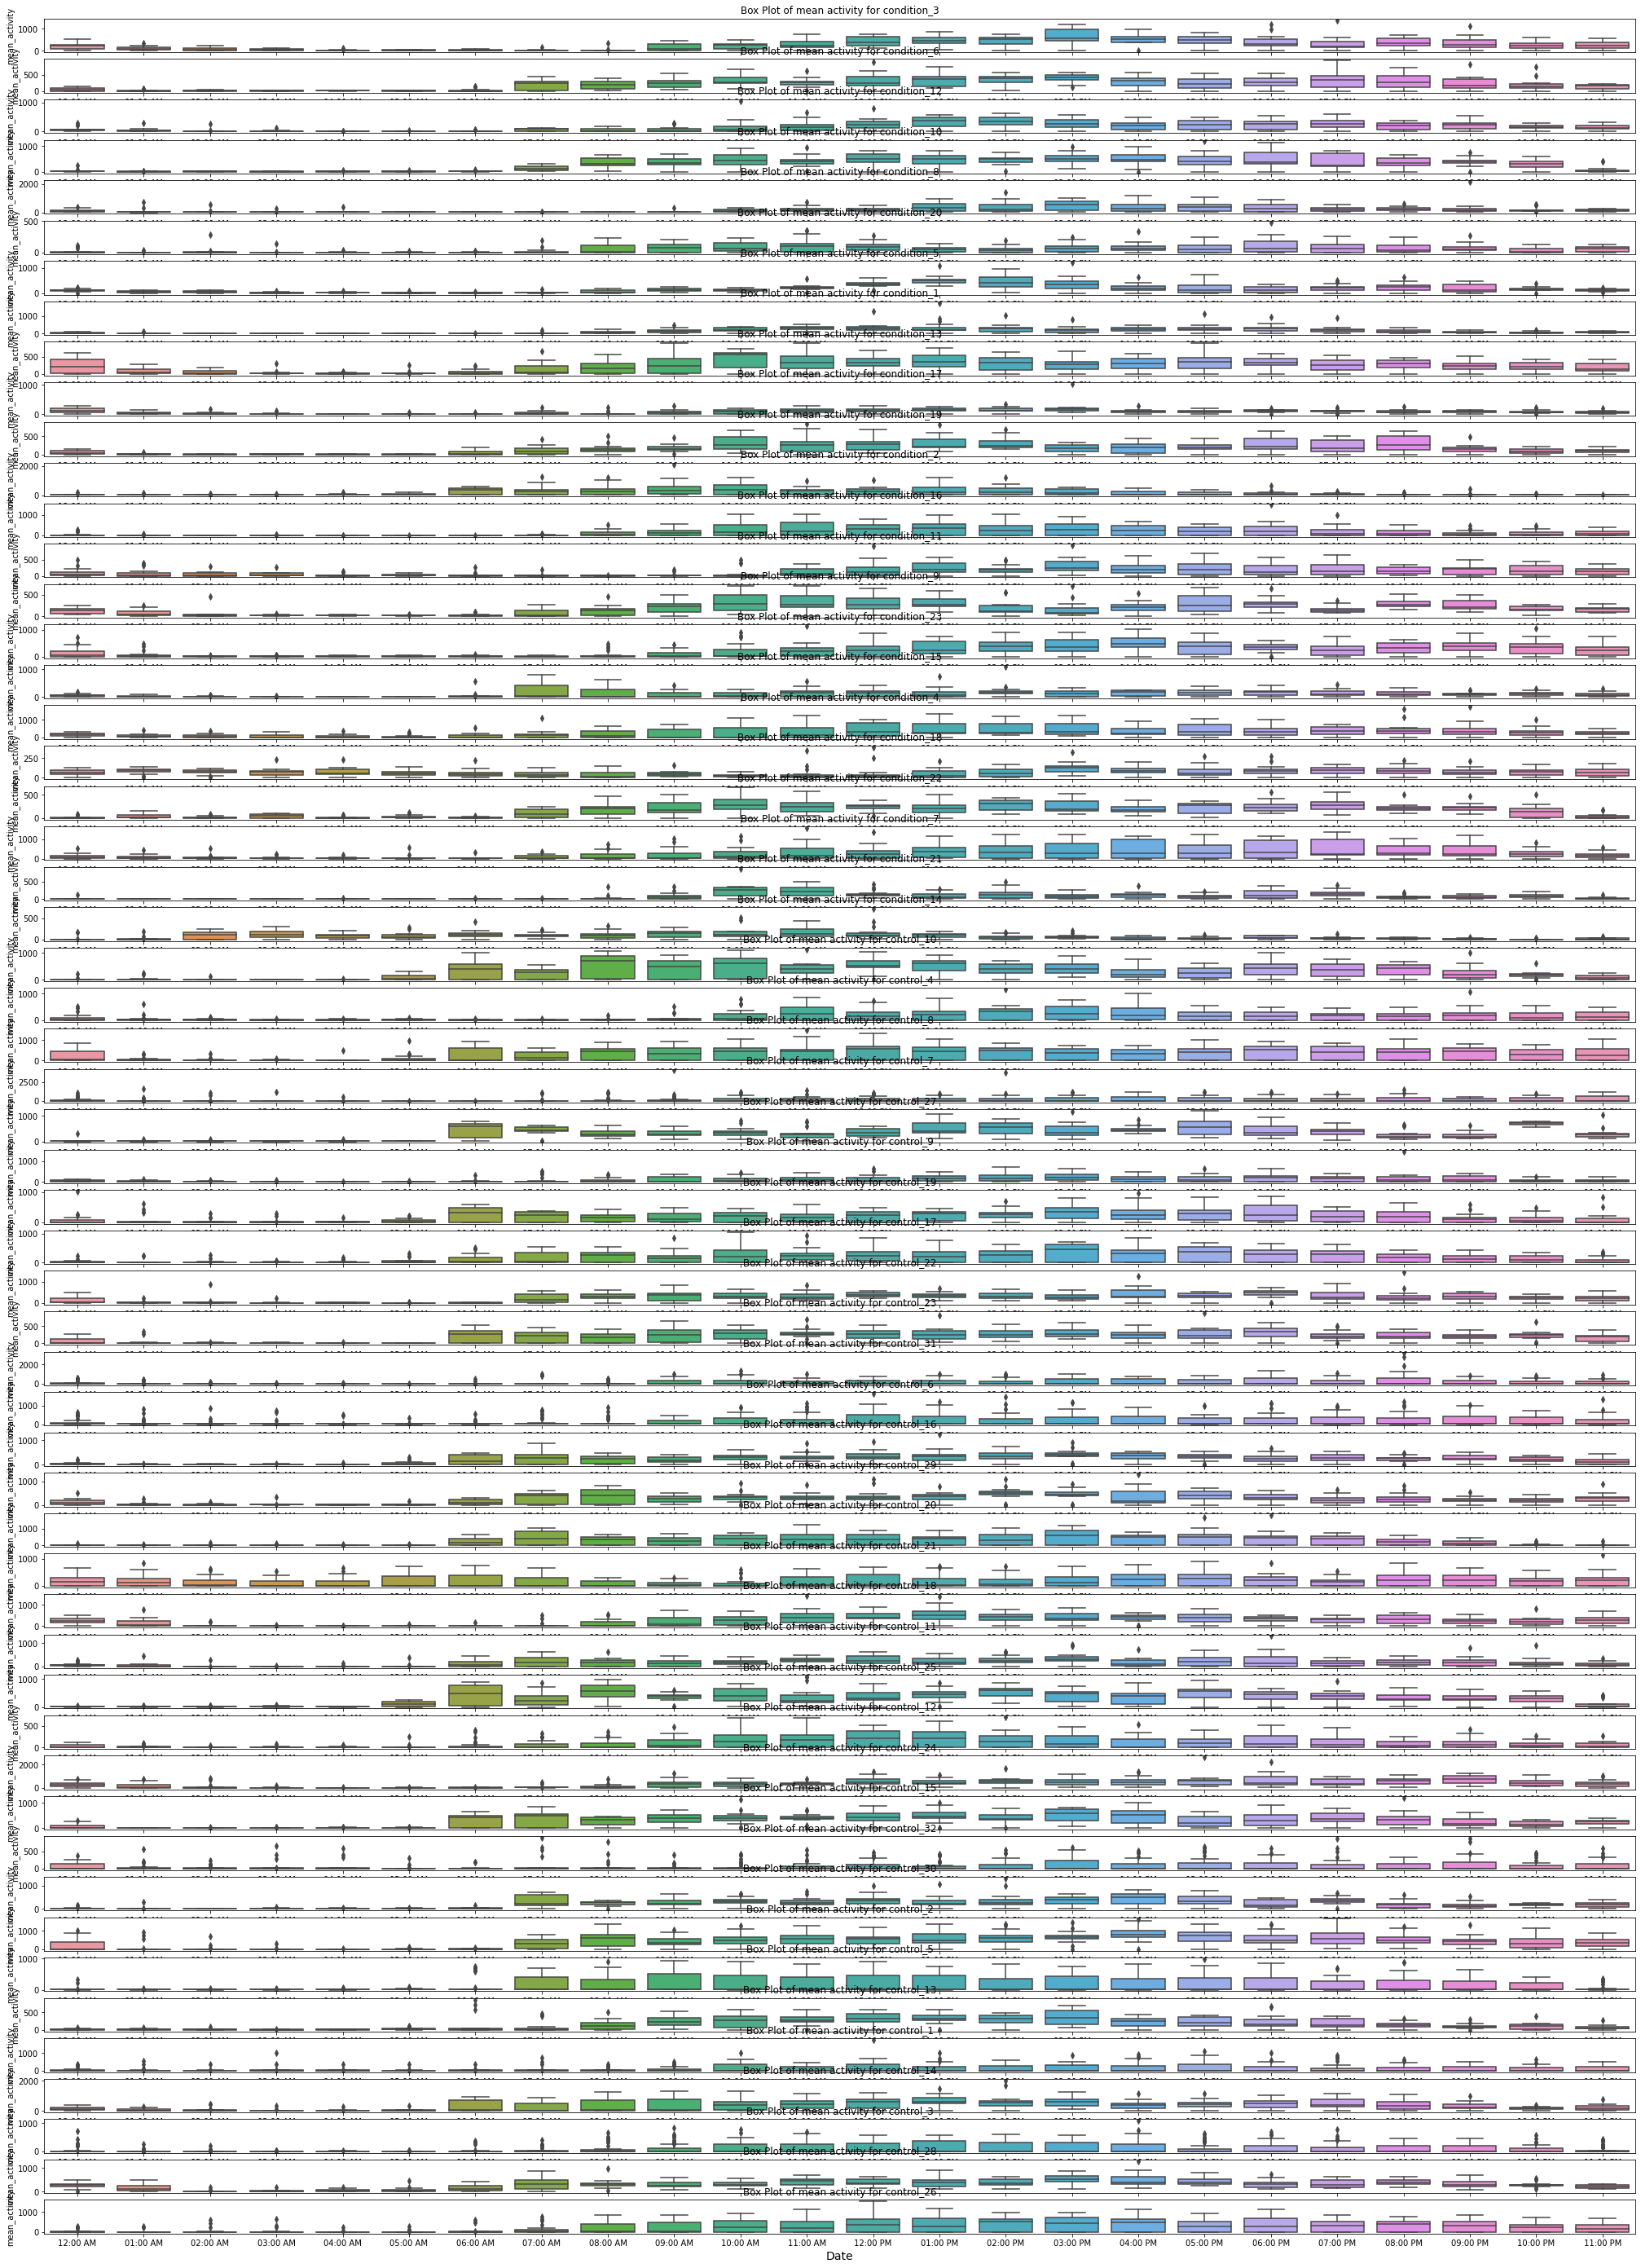

In [ ]:
#Now we are ploting mean_activity on the y axis and the hour on the x-axis as a box plot instead for the condition data
# Draw Plot
fig, axes = plt.subplots(55, 1, figsize=(35, 50))

cnt = 0
for i in range(55):
    df = super_array[i].reset_index()
    # Prepare data
    df['hour'] = [d.hour for d in df.timestamp]
    df = df.sort_values('hour')
    df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
    #Plotting stuff - Needs to change ".boxplot" into function that works for
    sns.boxplot(x='clock_hour', y='mean_activity', data=df, ax=axes[i])
    axes[i].set_title(f'Box Plot of mean activity for {df.source[1]}', fontsize=12)
    cnt += 1

plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=30.0)
plt.show()

In [ ]:
#super_df = pd.DataFrame(columns = ['mean_activity', 'source', 'state'])

#For loop
average_df = []
std_df = []
zero_df = []
for i in range(55): # i is people, all control & condition?
    df = super_array[i].reset_index()
    # Prepare data
    df['hour'] = [d.hour for d in df.timestamp]
    df = df.sort_values('hour')
    source = df['source']
    hour = df['hour']
    state = df['state']
    mean_activity = df['mean_activity']
    std_activity = df['std_activity']
    zero_activity = df['zero_activity_proportion']
    average_df.append(pd.DataFrame({'hour': hour, 'source': source, 'mean_activity': mean_activity, 'state':state}).groupby(["hour", "source"], as_index=False).mean())
    std_df.append(pd.DataFrame({'hour': hour, 'source': source, 'std_activity': std_activity, 'state':state}).groupby(["hour", "source"], as_index=False).mean())
    zero_df.append(pd.DataFrame({'hour': hour, 'source': source, 'zero_activity': zero_activity, 'state':state}).groupby(["hour", "source"], as_index=False).mean())
    fullest_df = pd.DataFrame().append(average_df)

#print(zero_df) # this is actually a list of objects, size 55(subjects)x24(hours)x4(columns), not dataframe!

In [ ]:
# List -> numpy array, check shape
# shape is 55(subjects)x24(hours)x4(columns: hour,person,average,label)
data_2d = np.array(average_df)
data_2d_std = np.array(std_df)
data_2d_zero = np.array(zero_df)

In [ ]:
# Goal: 55(subjects)x24(hour averages) as 55 inputs, 1x55(subjects) label vector
data_bm = np.concatenate((data_2d[:,:,2], data_2d_std[:,:,2], data_2d_zero[:,:,2]), axis = 1) # 55 x 24
labels_bm = data_2d[:,:,3] # 55 x 24
labels_bm = np.mean(labels_bm,1) # need 1 value per person, not the same value repeated 24 times!

# dtype object -> np array
data_bm = data_bm.astype(np.float32)
labels_bm = labels_bm.astype(np.float32)


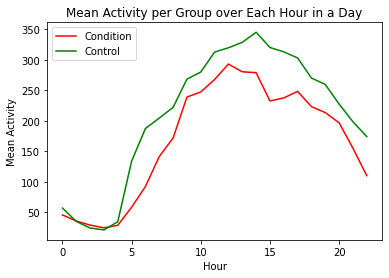

In [ ]:
# Plot the data! Does it look seperable / learnable?
#Make sure the labels is correct!
# Since they are still in order, we can just take the first 23 as condition
plt.title("Mean Activity per Group over Each Hour in a Day")
plt.plot(np.mean(data_bm[1:24,1:24],0), 'r',label="Condition")
plt.plot(np.mean(data_bm[24:56,1:24],0),'g',label="Control")
plt.xlabel("Hour")
plt.ylabel("Mean Activity")
plt.legend()

# Maybe! Whats the standard deviation?
#X-axis is hour in a day, and y-axis is mean of

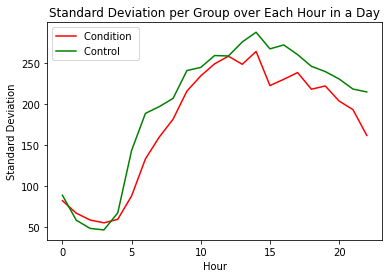

In [ ]:
plt.title("Standard Deviation per Group over Each Hour in a Day")
plt.plot(np.mean(data_bm[1:24,25:48],0), 'r',label="Condition ")
plt.plot(np.mean(data_bm[24:56,25:48],0),'g',label="Control ")
plt.xlabel("Hour")
plt.ylabel("Standard Deviation")
plt.legend()

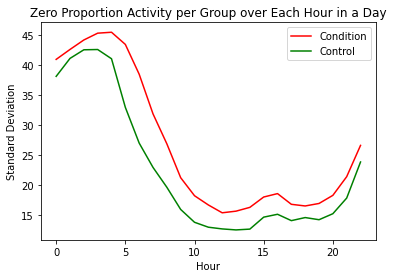

In [ ]:
plt.title("Zero Proportion Activity per Group over Each Hour in a Day")
plt.plot(np.mean(data_bm[1:24,49:73],0), 'r',label="Condition")
plt.plot(np.mean(data_bm[24:56,49:73],0),'g',label="Control")
plt.xlabel("Hour")
plt.ylabel("Standard Deviation")
plt.legend()

# **# BM Modeling**

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.utils.data as data_utils
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from sklearn.model_selection import KFold
import random
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torch.nn import functional as F


input_size = 72         # size of input layer, 24 for 24 hour averages (will change to 48 for std & 72 for zero porportion)
#Change these parameters (except num_classes) to increase accuracy and learning
hidden_size = 210        # number of __ in hidden layer
num_classes = 2          # numbers 0-1 for Depression
num_epochs = 26         # train on all data 10 times
batch_size = 4     # how many samples to train / test on at once. 5 since we only have 55 data points
k=5
splits=KFold(n_splits=k,shuffle=True,random_state=42)
learning_rate =  0.00075      # controls step size of optimizer!


class DepressionDataset(Dataset):
  def __init__(self, activity, labels):
        self.labels = labels
        self.activity = activity

  def __len__(self):
        return len(self.labels)

  def __getitem__(self, idx):
        label = self.labels[idx]
        activity = self.activity[idx,:]
        return activity, label

In [ ]:
data_tensor = torch.tensor(data_bm)
labels_tensor = torch.tensor(labels_bm)
labels_tensor = labels_tensor.type(torch.LongTensor)

train_dataset = DepressionDataset(data_tensor, labels_tensor)
test_dataset = DepressionDataset(data_tensor, labels_tensor)


# Importing the Dataloader & specify Batch size(half of full_df which is 572)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

#stuff for 10 cross fold validation
dataset = train_dataset
foldperf={}

In [ ]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    # __init__ defines the types of layers you want to include in your network
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.drop = torch.nn.Dropout(p=0.5, inplace=False) #maybe get rid of later, add more layers
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.l4 = nn.Linear(hidden_size, num_classes)

    # forward defines the sequential order of the layers defined in __init__. Forward Propogation
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        #out = self.relu(out)
        #out = self.l4(out)
        # no activation and no softmax at the end
        return out

# Creating an instance of the above model
model = NeuralNet(input_size, hidden_size, num_classes)

# Defining our loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [ ]:
## Untrained accuracy - whats the baseline?
# Note - this is the same as the testing loop below but using training data!
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for activity, labels in train_loader:
        outputs = model(activity)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

# Print The Total Accuracy of Untrained Network
acc = 100.0 * n_correct / n_samples
print(f'Accuracy of the untrained network on the training data: {acc} %')

Accuracy of the untrained network on the training data: 0.0 %


# 10 Cross fold validation



In [ ]:
def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:
        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct

In [ ]:
def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:
        images,labels = images.to(device),labels.to(device)
        output = model(images)
        loss=loss_fn(output,labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct+=(predictions == labels).sum().item()

    return valid_loss,val_correct

In [ ]:

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = NeuralNet(input_size, hidden_size, num_classes)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    scheduler = ExponentialLR(optimizer, gamma=0.991)


    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer)
        test_loss, test_correct=valid_epoch(model,device,test_loader,criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

    foldperf['fold{}'.format(fold+1)] = history

torch.save(model,'k_cross_CNN.pt')

Fold 1
Epoch:1/26 AVG Training Loss:13.318 AVG Test Loss:5.026 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:2/26 AVG Training Loss:3.246 AVG Test Loss:3.748 AVG Training Acc 68.18 % AVG Test Acc 54.55 %
Epoch:3/26 AVG Training Loss:3.119 AVG Test Loss:4.685 AVG Training Acc 56.82 % AVG Test Acc 54.55 %
Epoch:4/26 AVG Training Loss:1.232 AVG Test Loss:1.447 AVG Training Acc 86.36 % AVG Test Acc 90.91 %
Epoch:5/26 AVG Training Loss:0.416 AVG Test Loss:1.376 AVG Training Acc 88.64 % AVG Test Acc 81.82 %
Epoch:6/26 AVG Training Loss:0.135 AVG Test Loss:0.774 AVG Training Acc 95.45 % AVG Test Acc 90.91 %
Epoch:7/26 AVG Training Loss:0.123 AVG Test Loss:1.104 AVG Training Acc 93.18 % AVG Test Acc 81.82 %
Epoch:8/26 AVG Training Loss:0.072 AVG Test Loss:1.096 AVG Training Acc 95.45 % AVG Test Acc 90.91 %
Epoch:9/26 AVG Training Loss:0.040 AVG Test Loss:0.903 AVG Training Acc 100.00 % AVG Test Acc 81.82 %
Epoch:10/26 AVG Training Loss:0.038 AVG Test Loss:1.056 AVG Training Acc 97.73 % A

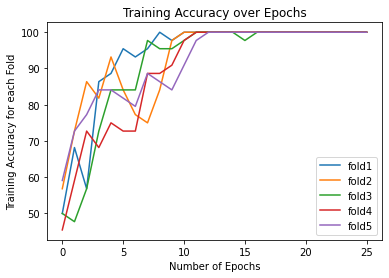

In [ ]:
for f in range(1,k+1):
    plt.title("Training Accuracy over Epochs")
    plt.plot(foldperf['fold{}'.format(f)]['train_acc'], label="fold"+str(f))
    plt.ylabel("Training Accuracy for each Fold")
    plt.legend(loc='lower right')
    plt.xlabel("Number of Epochs")


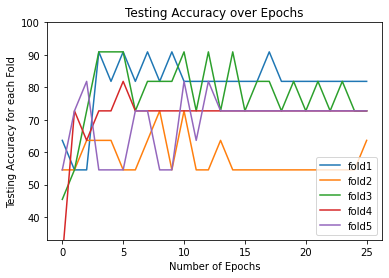

In [ ]:
for f in range(1,k+1):
    plt.title("Testing Accuracy over Epochs")
    plt.plot(foldperf['fold{}'.format(f)]['test_acc'], label="fold"+str(f))
    plt.ylabel("Testing Accuracy for each Fold")
    plt.legend(loc='lower right')
    plt.ylim([33,100])
    plt.xlabel("Number of Epochs")

In [ ]:
testl_f,tl_f,testa_f,ta_f=[],[],[],[]
k=4
for f in range(1,k+1):

     tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
     testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

     ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
     testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_acc']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Test Acc: {:.2f}".format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))


Performance of 4 fold cross validation
Average Training Loss: 1.024 	 Average Test Loss: 1.596 	 Average Training Acc: 91.70 	 Average Test Acc: 71.94
